In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import transport_qmc.targets as Targets
from transport_qmc.tqmc import TransportQMC
from transport_qmc.train import lbfgs
from transport_qmc.utils import sample_uniform

### Set up the target distribution

In [3]:
posterior_name = 'nes_logit'
data_file = f"stan/{posterior_name}.json"
target = getattr(Targets, posterior_name)(data_file)
d = target.d
print("Dimension =", d)

Dimension = 2


### Set up normalizing flow

In [4]:
model = TransportQMC(d, target, num_composition=1, max_deg=7)
params = model.init_params()

get_kl = jax.jit(model.reverse_kl)  # use reverse KL as loss function
get_ess = jax.jit(model.ess) # use ESS as validation metric

In [5]:
rng = np.random.default_rng(1)
nsample = 2**8

U_train = jnp.array(sample_uniform(nsample, d, rng, 'rqmc'))
loss_fn = lambda params: get_kl(params, U_train)

U_val = jnp.array(sample_uniform(nsample, d, rng, 'rqmc')) 
val_fn = lambda params: get_ess(params, U_val)

### Training normalizing flow

In [6]:
final_state, ess_trace = lbfgs(loss_fn, params, val_fn, max_iter=100, max_lr=1.)

Running for 100 iterations: 100%|██████████| 100/100 [00:02<00:00, 37.71it/s]


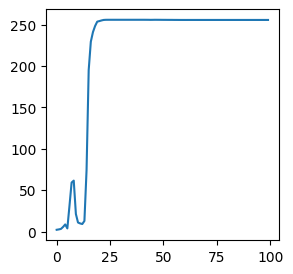

In [7]:
# plot ESS versus iterations
plt.figure(figsize=(3, 3))
plt.plot(ess_trace)

### Generate samples from the trained flow

In [8]:
params = final_state[0]
nf_samples, log_weights = model.sample(params, 2**10, 10)

In [9]:
weights = jnp.exp(log_weights - jnp.max(log_weights))
moments_1 = jnp.sum(weights[:, None] * nf_samples, axis=0) / jnp.sum(weights)
moments_2 = jnp.sum(weights[:, None] * nf_samples**2, axis=0) / jnp.sum(weights)

In [10]:
print("first moment ", moments_1)
print("second moment", moments_2)

first moment  [-1.3544532  0.3121984]
second moment [1.8687994 0.100577 ]


### Compare with MCMC

In [11]:
from numpyro.infer import NUTS, MCMC

nuts_kernel = NUTS(target.numpyro_model)
num_chains = 4
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=1000, num_chains=num_chains)
mcmc.run(jax.random.key(1))

mcmc_results = mcmc.get_samples()

/var/folders/2t/1700w5797qz0nckmtyxxg61m0000gn/T/ipykernel_85969/2212093125.py:5: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=1000, num_chains=num_chains)
sample: 100%|██████████| 1100/1100 [00:00<00:00, 3307.59it/s, 3 steps of size 1.53e-01. acc. prob=0.96]


In [12]:
param_names = target.param_unc_names()
mcmc_samples_unc = None
for key in param_names:
    sample = mcmc_results[key]
    if sample.ndim == 1:
        sample = sample.reshape(-1, 1)
    if mcmc_samples_unc is None:
        mcmc_samples_unc = sample
    else:
        mcmc_samples_unc = np.concatenate([mcmc_samples_unc, sample], axis=1)

mcmc_samples = target.param_constrain(mcmc_samples_unc)
mcmc_moments_1 = np.mean(mcmc_samples, axis=0)
mcmc_moments_2 = np.mean(mcmc_samples**2, axis=0)

print("MCMC first moment ", mcmc_moments_1)
print("MCMC second moment", mcmc_moments_2)

MCMC first moment  [-1.3588352   0.31335315]
MCMC second moment [1.8816063  0.10134416]


### Histogram of samples

(array([0.10501648, 0.36755766, 1.47023065, 3.80684723, 6.48476735,
        6.87857913, 4.69948727, 2.25785422, 0.68260709, 0.13127059]),
 array([0.11985704, 0.15705358, 0.19425012, 0.23144667, 0.26864321,
        0.30583976, 0.3430363 , 0.38023285, 0.41742939, 0.45462594,
        0.49182248]),
 <BarContainer object of 10 artists>)

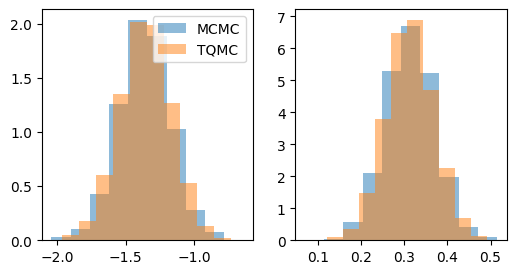

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

ax[0].hist(mcmc_samples[:, 0], alpha=0.5, density=True, label='MCMC')
ax[0].hist(nf_samples[:, 0], alpha=0.5, density=True, label='TQMC')
ax[0].legend()

ax[1].hist(mcmc_samples[:, 1], alpha=0.5, density=True)
ax[1].hist(nf_samples[:, 1], alpha=0.5, density=True)